

```
# 코드로 형식 지정됨
```

## Readme

if you want to use the nthu dataset, please change the file location. that is on the last cell

In [ ]:
!pip install mediapipe
import pandas as pd
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()           # 실행하면 파일 선택 창 뜸

import os, shutil, pathlib, json

kaggle_json = next(iter(uploaded))
pathlib.Path("~/.kaggle").expanduser().mkdir(exist_ok=True)
shutil.move(kaggle_json, os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

print("✓ kaggle.json 등록 완료")

Saving kaggle.json to kaggle.json
✓ kaggle.json 등록 완료


# Download dataset

In [ ]:
!kaggle datasets download -d rakibuleceruet/drowsiness-prediction-dataset
!kaggle datasets download -d adinishad/prediction-images

Dataset URL: https://www.kaggle.com/datasets/rakibuleceruet/drowsiness-prediction-dataset
License(s): unknown
 98% 2.12G/2.17G [00:02<00:00, 652MB/s]
100% 2.17G/2.17G [00:02<00:00, 918MB/s]
Dataset URL: https://www.kaggle.com/datasets/adinishad/prediction-images
License(s): unknown
  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18M [00:00<00:00, 576MB/s]


# Unzip dataset

In [ ]:
!unzip drowsiness-prediction-dataset.zip
!unzip prediction-images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: 0 FaceImages/Active Subjects/img_k_12330.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12360.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12390.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12420.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12450.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12480.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12510.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12540.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12570.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12600.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12630.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12660.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12690.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12720.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12750.jpg  
  inflating: 0 FaceImages/Active Subjects/img_k_12780.jpg  
  in

In [ ]:
os.makedirs('./Fatigue Subjects')
os.makedirs('./Active Subjects')

Image preprocessing

In [ ]:
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)


all_left_eye_idxs = set(np.ravel(all_left_eye_idxs))

all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))

all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)

chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

In [ ]:
IMG_SIZE=145
i=0
def draw(
    *,n=i,
    img_dt,cat,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    image_drawing_tool = img_dt

    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness,
        circle_radius=ts_circle_radius,
        color=(255, 255, 255)
    )


    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
    landmarks = face_landmarks.landmark


    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(image_eye_lmks,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x,
                                                landmark.y,
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen,
                       pred_cord,
                       lmk_circle_radius,
                       (255, 255, 255),
                       -1
                       )

    if cat=='Fatigue Subjects':
        cv2.imwrite(str('./Fatigue Subjects/'+str(n)+'.jpg'), image_drawing_tool)
    else:
        cv2.imwrite(str('./Active Subjects/'+str(n)+'.jpg'), image_drawing_tool)

    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE))
    return resized_array

In [ ]:
imgH, imgW, _=0,0,0
def landmarks(image,category,i):
    resized_array=[]
    IMG_SIZE = 145
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

     ith mp_facemesh.FaceMesh(
        static_image_mode=True,         # Default=False
        max_num_faces=1,                # Default=1
        refine_landmarks=False,         # Default=False
        min_detection_confidence=0.5,   # Default=0.5
        min_tracking_confidence= 0.5,) as face_mesh:

        results = face_mesh.process(image)

        if results.multi_face_landmarks:
            for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
                resized_array= draw(img_dt=image.copy(), cat=category, n=i,face_landmarks=face_landmarks)
    return resized_array

In [ ]:
def face_for_yawn(direc="/content/0 FaceImages", face_cas_path="/content/haarcascade_frontalface_default.xml"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                land_face_array=landmarks(roi_color,category,i)
                yaw_no.append([land_face_array, class_num1])
                i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


In [ ]:
%%bash
SRC="/content/drive/MyDrive/DDD"   # 드라이브에 있는 폴더
DST="/content"                     # 원래 Colab 작업 디렉터리
p -a "${SRC}/." "${DST}/"

echo "✓ 복사 완료 → ${DST}"

✓ 복사 완료 → /content


In [ ]:
dir_path = r'./Active Subjects'
print("Number of Active images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Active images :
3869


In [ ]:
dir_path = r'./Fatigue Subjects'
print("Number of Fatigue images :")
print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

Number of Fatigue images :
3669


In [ ]:
categories = ["Fatigue Subjects", "Active Subjects"]
for category in categories:
  for idx, img in enumerate(os.listdir(f'./{category}')):
      if idx > 5:
        break
      img_file = cv2.imread(f'./{category}/{img}')
      plt.imshow(img_file)
      plt.show()
      plt.close()

Output hidden; open in https://colab.research.google.com to view.

Resizing Images

In [ ]:
import os
import time
def face_for_yawn(direc="./"):
    yaw_no=[]
    i=1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            yaw_no.append([resized_array, class_num1])
                #print('image face number '+str(i))
                #i=i+1
    return yaw_no
yawn_no_yawn = face_for_yawn()

0
1


Seperate label and features

In [ ]:
X = []
y = []
for feature, label in yawn_no_yawn:
    X.append(feature)
    y.append(label)

Reshape the array

In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

Label encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

Splitting

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
len(X_test)

1508

In [ ]:
len(X_train)

6030

Data Augmentation

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

## Saving the model

Epoch 01: Train Loss=0.7001, Acc=0.5088 | Val Loss=0.6796, Acc=0.5802
Epoch 02: Train Loss=0.6848, Acc=0.5368 | Val Loss=0.6623, Acc=0.6313
Epoch 03: Train Loss=0.6604, Acc=0.5677 | Val Loss=0.6300, Acc=0.6664
Epoch 04: Train Loss=0.6324, Acc=0.5829 | Val Loss=0.5889, Acc=0.7003
Epoch 05: Train Loss=0.6028, Acc=0.6133 | Val Loss=0.5391, Acc=0.7361
Epoch 06: Train Loss=0.5798, Acc=0.6081 | Val Loss=0.5082, Acc=0.7414
Epoch 07: Train Loss=0.5618, Acc=0.6362 | Val Loss=0.4916, Acc=0.7454
Epoch 08: Train Loss=0.5517, Acc=0.6254 | Val Loss=0.4761, Acc=0.7639
Epoch 09: Train Loss=0.5502, Acc=0.6403 | Val Loss=0.4871, Acc=0.7513
Epoch 10: Train Loss=0.5470, Acc=0.6284 | Val Loss=0.4545, Acc=0.7613
Epoch 11: Train Loss=0.5304, Acc=0.6433 | Val Loss=0.4490, Acc=0.7719
Epoch 12: Train Loss=0.5366, Acc=0.6352 | Val Loss=0.4279, Acc=0.7805
Epoch 13: Train Loss=0.5168, Acc=0.6537 | Val Loss=0.4409, Acc=0.8057
Epoch 14: Train Loss=0.5253, Acc=0.6381 | Val Loss=0.4437, Acc=0.8064
Epoch 15: Train Loss

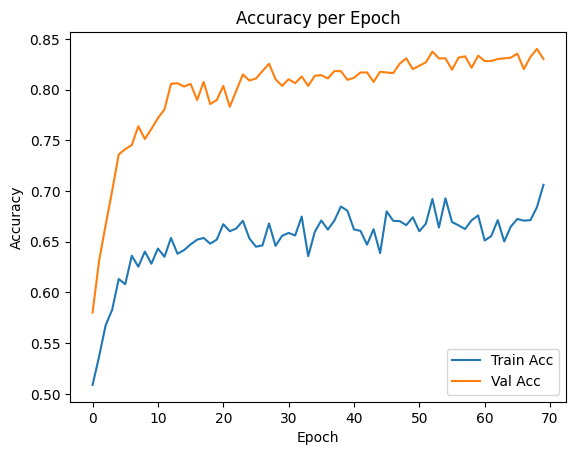

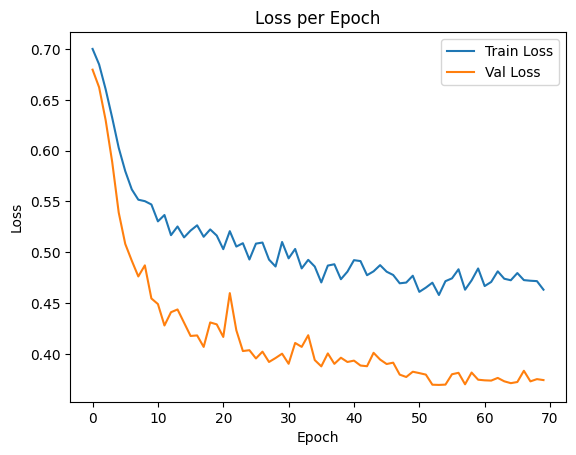

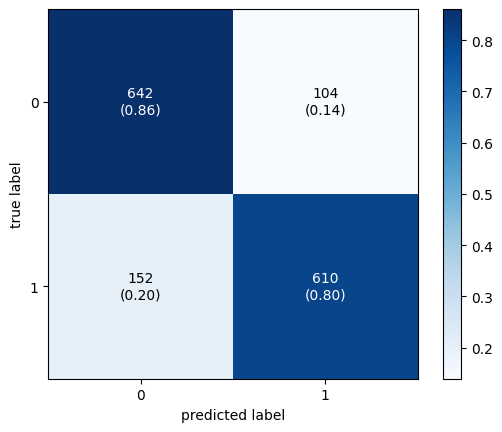

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from pytorchcv.model_provider import get_model
import numpy as np

class NumpyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

X_train_t = torch.from_numpy(np.array(X_train)).permute(0,3,1,2).float()
y_train_t = torch.from_numpy(np.array(y_train)).float().unsqueeze(1)
X_test_t  = torch.from_numpy(np.array(X_test)).permute(0,3,1,2).float()
y_test_t  = torch.from_numpy(np.array(y_test)).float().unsqueeze(1)

train_transforms = T.Compose([
    T.ToPILImage(),
    T.RandomAffine(degrees=30, scale=(0.8,1.2)),
    T.RandomHorizontalFlip(p=0.5),
    T.Resize((145,145)),
    T.ToTensor(),
])

test_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((145,145)),
    T.ToTensor(),
])

train_ds = NumpyDataset(X_train_t, y_train_t, transform=train_transforms)
test_ds  = NumpyDataset(X_test_t,  y_test_t,  transform=test_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

class MobileNet_LSTM(nn.Module):
    def __init__(self):
        super(MobileNet_LSTM, self).__init__()
        full_model = get_model('mobilenet_w1', pretrained=True)
        layers = list(full_model.features.children())
        if isinstance(layers[-1], (nn.AvgPool2d, nn.AdaptiveAvgPool2d)):
            layers = layers[:-1]
        self.backbone = nn.Sequential(*layers)
        for p in self.backbone.parameters():
            p.requires_grad = False
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.lstm = nn.LSTM(input_size=1024, hidden_size=64, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(64,128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.5),
            nn.Linear(128,64), nn.ReLU(), nn.Dropout(0.25),
            nn.Linear(64,1), nn.Sigmoid()
        )
    def forward(self, x):
        B = x.size(0)
        f = self.backbone(x)
        f = self.gap(f).view(B,1024)
        seq = f.unsqueeze(1)
        out, _ = self.lstm(seq)
        out = out.squeeze(1)
        return self.classifier(out)
#training opt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileNet_LSTM().to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=70
)

def mixup_data(x, y, alpha=0.4):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(1, 71):
    model.train()
    total_loss = total_acc = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        # apply mixup
        xb_mix, y_a, y_b, lam = mixup_data(xb, yb)
        preds = model(xb_mix)
        loss = lam * criterion(preds, y_a) + (1 - lam) * criterion(preds, y_b)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * xb.size(0)
        total_acc += ((preds>0.5)==yb).sum().item()
    train_loss = total_loss / len(train_ds)
    train_acc = total_acc / len(train_ds)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    total_vloss = total_vacc = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            vloss = criterion(preds, yb)
            total_vloss += vloss.item() * xb.size(0)
            total_vacc += ((preds>0.5)==yb).sum().item()
    val_loss = total_vloss / len(test_ds)
    val_acc = total_vacc / len(test_ds)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch:02d}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}')

torch.save(model.state_dict(), 'mobileNet_finetuned_model.pth')

# --- Plotting Results ---
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Plot training & validation accuracy
plt.figure()
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix on Test Set
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        all_preds.extend((preds>0.5).cpu().numpy().astype(int))
        all_labels.extend(yb.numpy().astype(int))
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plot_confusion_matrix(
    conf_mat=cm,
    show_absolute=True,
    show_normed=True,
    colorbar=True
)
plt.show()


In [ ]:
torch.save(model.state_dict(), 'mobileNet_finetuned_model.pth')


Extracting features: 66521/66521
Feature extraction completed.
Creating sequences: 61894/61894
Sequence creation completed.
Epoch 001 | Train 0.6278/0.6464 | Val 0.5841/0.6871
Epoch 002 | Train 0.5856/0.6837 | Val 0.5597/0.6963
Epoch 003 | Train 0.5716/0.6895 | Val 0.5463/0.7013
Epoch 004 | Train 0.5622/0.6956 | Val 0.5407/0.7042
Epoch 005 | Train 0.5546/0.6985 | Val 0.5477/0.7144
Epoch 006 | Train 0.5498/0.7063 | Val 0.5396/0.7151
Epoch 007 | Train 0.5462/0.7089 | Val 0.5495/0.7018
Epoch 008 | Train 0.5442/0.7108 | Val 0.5196/0.7379
Epoch 009 | Train 0.5410/0.7138 | Val 0.5189/0.7406
Epoch 010 | Train 0.5391/0.7134 | Val 0.5262/0.7265
Epoch 011 | Train 0.5353/0.7185 | Val 0.5278/0.7201
Epoch 012 | Train 0.5335/0.7196 | Val 0.5298/0.7112
Epoch 013 | Train 0.5320/0.7214 | Val 0.5231/0.7272
Epoch 014 | Train 0.5323/0.7202 | Val 0.5249/0.7173
Epoch 015 | Train 0.5277/0.7239 | Val 0.5202/0.7234
Epoch 016 | Train 0.5278/0.7228 | Val 0.5349/0.7096
Epoch 017 | Train 0.5270/0.7244 | Val 0.5210

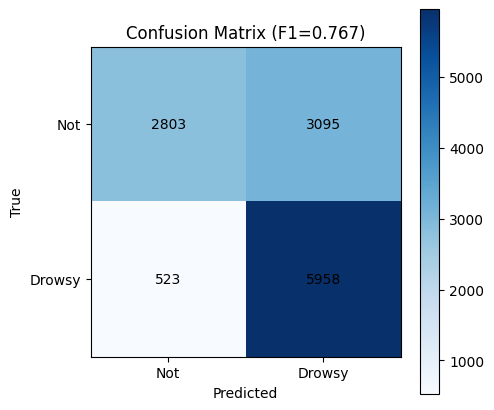

In [ ]:
import os
import glob
import time

import cv2
import numpy as np
import mediapipe as mp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score

# 1) Feature extraction (MediaPipe FaceMesh)
mp_face    = mp.solutions.face_mesh
face_mesh  = mp_face.FaceMesh(static_image_mode=False,
                              max_num_faces=1,
                              refine_landmarks=True,
                              min_detection_confidence=0.5,
                              min_tracking_confidence=0.5)
LEFT_EYE   = [[263,362],[387,373],[386,374],[385,380]]
RIGHT_EYE  = [[33,133],[160,144],[159,145],[158,153]]
MOUTH      = [[61,291],[39,181],[0,17],[269,405]]
MIN_DIST   = 2.0

def distance(a, b):
    return np.linalg.norm(a[:2] - b[:2])

def eye_aspect(lm, idxs):
    D = distance(lm[idxs[0][0]], lm[idxs[0][1]])
    if D <= 0: return 0.0
    N = sum(distance(lm[i], lm[j]) for i, j in idxs[1:]) / 3
    return N / D

def extract_features(path):
    img = cv2.imread(path)
    if img is None: return None
    img = cv2.resize(img, (640, 480))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res = face_mesh.process(rgb)
    if not res.multi_face_landmarks: return None
    pts = np.array([[p.x * 640, p.y * 480, p.z]
                    for p in res.multi_face_landmarks[0].landmark])
    for idxs in (LEFT_EYE, RIGHT_EYE, MOUTH):
        for i, j in idxs:
            if distance(pts[i], pts[j]) < MIN_DIST:
                return None
    ear = 0.5 * (eye_aspect(pts, LEFT_EYE) + eye_aspect(pts, RIGHT_EYE))
    mar = eye_aspect(pts, MOUTH)
    if ear <= 0 or mar <= 0: return None
    puc = 1.0
    moe = mar / ear
    return [ear, mar, puc, moe]

# 2) Dataset: sliding window of 5 frames → sequence
class DrowsinessDataset(Dataset):
    def __init__(self, root_dir, window=5):
        # collect image paths
        paths, labels = [], []
        for label, sub in enumerate(['notdrowsy', 'drowsy']):
            folder = os.path.join(root_dir, sub)
            for img_path in glob.glob(f"{folder}/*.jpg"):
                paths.append(img_path); labels.append(label)
        total = len(paths)
        feats, labs = [], []
        # extract features with progress
        print(f"Extracting features: 0/{total}", end='')
        for idx, (p, l) in enumerate(zip(paths, labels), 1):
            f = extract_features(p)
            if f is not None:
                feats.append(f); labs.append(l)
            if idx % 100 == 0 or idx == total:
                print(f"\rExtracting features: {idx}/{total}", end='')
        print("\nFeature extraction completed.")
        # sliding window
        X, y = [], []
        seq_total = len(feats) - window + 1
        print(f"Creating sequences: 0/{seq_total}", end='')
        for i in range(seq_total):
            block = feats[i:i + window]
            lbls = labs[i:i + window]
            c0, c1 = lbls.count(0), lbls.count(1)
            if c0 >= 3 or c1 >= 3:
                X.append(block)
                y.append(0 if c0 > c1 else 1)
            if (i + 1) % 100 == 0 or i + 1 == seq_total:
                print(f"\rCreating sequences: {i+1}/{seq_total}", end='')
        print("\nSequence creation completed.")
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# 3) Deeper LSTM model with dropout, batchnorm
class DrowsinessLSTM(nn.Module):
    def __init__(self, window=5, feat_dim=4, hidden=128, lstm_layers=3):
        super().__init__()
        self.pre_fc = nn.Sequential(
            nn.Linear(window * feat_dim, window * hidden),
            nn.ReLU(),
            nn.BatchNorm1d(window * hidden),
            nn.Dropout(0.5)
        )
        self.lstm = nn.LSTM(input_size=hidden,
                            hidden_size=hidden,
                            num_layers=lstm_layers,
                            batch_first=True,
                            dropout=0.2)
        self.fc_stack = nn.Sequential(
            nn.Linear(hidden, 512), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 64),  nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 8),    nn.ReLU(), nn.Dropout(0.1)
        )
        self.out = nn.Sequential(
            nn.Linear(8, 1), nn.Sigmoid()
        )
    def forward(self, x):
        b = x.size(0)
        x = x.view(b, -1)
        x = self.pre_fc(x)
        x = x.view(b, -1, x.size(-1) // 5)
        _, (h_n, _) = self.lstm(x)
        h = h_n[-1]
        h = self.fc_stack(h)
        return self.out(h)

# 4) Training setup
root = '/content/drive/MyDrive/DDD/train_data'
dataset = DrowsinessDataset(root)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DrowsinessLSTM().to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

best_val_acc = 0.0
for epoch in range(1, 101):
    model.train()
    tl, ta = 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        tl += loss.item() * xb.size(0)
        ta += ((pred > 0.5) == yb).sum().item()
    tr_loss, tr_acc = tl / len(train_ds), ta / len(train_ds)

    model.eval()
    vl, va = 0.0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            vl += criterion(pred, yb).item() * xb.size(0)
            va += ((pred > 0.5) == yb).sum().item()
    val_loss, val_acc = vl / len(val_ds), va / len(val_ds)

    print(f"Epoch {epoch:03d} | Train {tr_loss:.4f}/{tr_acc:.4f} | Val {val_loss:.4f}/{val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        scripted = torch.jit.script(model)
        scripted.save('clf_lstm_deep.pth')

print(f"Best Val Acc: {best_val_acc:.4f}")

# 5) Confusion matrix & F1 score
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        pred = (model(xb) > 0.5).int().cpu().numpy().flatten()
        all_preds.extend(pred.tolist())
        all_labels.extend(yb.numpy().flatten().tolist())
cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues')
plt.title(f'Confusion Matrix (F1={f1:.3f})')
plt.colorbar()
plt.xticks([0,1], ['Not','Drowsy'])
plt.yticks([0,1], ['Not','Drowsy'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
